<a href="https://colab.research.google.com/github/clacri/CASP14_MR_evaluation/blob/main/CASP_ReLLG_Exploration_Results_Refinement_Category.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# First setting up steps

# Python imports
import os
import pandas as pd
#pd.show_versions()
from IPython.display import display
import numpy
from operator import itemgetter

# Google drive mounting to get the data
from google.colab import drive
from google.colab import files
drive.mount('/content/drive')


# Plotting related
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use(['/content/drive/MyDrive/DATA_FOR_NOTEBOOKS/mydefplot.mplstyle','seaborn-whitegrid'])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Second setting up step
# Locate the data in your drive
# In Claudia's case this category it is under /content/drive/MyDrive/DATA_FOR_NOTEBOOKS/Refinement_reLLG_tables
path_claudia_refinement_tables = "/content/drive/MyDrive/DATA_FOR_NOTEBOOKS/Refinement_reLLG_tables/"
# There is also information about which structures do have x-ray data
path_data = "/content/drive/MyDrive/DATA_FOR_NOTEBOOKS/targets_xray.csv"
# And which groups identifiers correspond with wich names
path_groups = "/content/drive/MyDrive/DATA_FOR_NOTEBOOKS/groups.csv"


# More info about experimental data
path_csv_all_methods = "/content/drive/MyDrive/DATA_FOR_NOTEBOOKS/target_experiment_types.csv"

In [ ]:
# Read in extra information

# About availability of x-ray data
df_data_xray = pd.read_csv(path_data, header=None)
df_data_xray.columns = ['Target']
list_xray_full = df_data_xray['Target'].tolist()
list_xray = [ele[1:] for ele in list_xray_full]
print('\nTargets with x-ray data',list_xray)
#display(df_data_xray)

# About availability of cryo-em data
# This info comes from the website https://predictioncenter.org/casp14/cryoem_results.cgi
# On that link there are multiple domains from the targets but I guess the target itself in full has the associated data
# Looking on the site, I found the cryoem targets are: H1036, T1026, T1036, T1092, T1093, T1094, T1095, T1096, T1099
# H1036 is a multimeric target but is the same structure that T1036, a cryoem structure with pdb id 6vn1
list_cryoem = ['1026', '1036', '1092', '1093', '1094', '1095', '1096', '1099']
print('\nTargets with CryoEM data',list_cryoem) 

# About the names of the groups
df_groups_key = pd.read_csv(path_groups,delimiter=';',dtype=str)
#display(df_groups_key)
df_groups_key.columns = ['Name_Group','Group','Type']
df_groups_key['Group'] = df_groups_key['Group'].astype(str)
del df_groups_key['Type']
#display(df_groups_key)
groupnames_dict = dict(zip(df_groups_key['Group'], df_groups_key['Name_Group']))
print("\nGroup names and numbers correspondence",groupnames_dict)

# Master csv with all experimental info now
df_global_methods= pd.read_csv(path_csv_all_methods,delimiter=',',dtype=str, header=None)
df_global_methods.columns = ['Target_Evaluation','Experimental_Method']
display(df_global_methods)




Targets with x-ray data ['1024', '1030', '1031', '1033 ', '1035', '1037', '1039', '1040', '1041', '1042', '1042', '1043', '1032', '1034', '1038', '1046', '1048', '1049', '1050', '1052', '1053', '1054', '1056', '1058', '1064', '1065', '1067', '1070', '1073', '1074', '1079', '1080', '1082', '1083', '1084', '1085', '1086', '1087', '1089', '1090', '1091', '1100', '1101']

Targets with CryoEM data ['1026', '1036', '1092', '1093', '1094', '1095', '1096', '1099']

Group names and numbers correspondence {'000': 'VoroMQA-stout', '002': 'VoroMQA-dark', '003': 'SHORTLE', '004': 'GAPF_LNCC', '005': 'Seder2020', '006': 'BrainFold', '009': 'tFold_human', '010': 'TripletRes', '013': 'FEIG-S', '014': 'xianmingpan', '015': 'AP_1', '018': 'UNRES-template', '024': 'DeepPotential', '026': 'NOVA', '027': 'SSThread', '029': 'Venclovas', '031': 'Zhang-CEthreader', '032': 'MESHI', '033': 'ishidalab', '035': 'ModFOLDclust2', '039': 'ropius0QA', '042': 'QUARK', '044': 'DeepML', '050': 'IntFOLD6', '052': 'GAPF_

,Target_Evaluation,Experimental_Method
0,T1024-D1,X-ray
1,T1024-D2,X-ray
2,T1025-D1,X-ray
3,T1026-D1,Cryo-EM
4,T1027-D1,NMR
...,...,...
91,T1099-D1,Cryo-EM
92,T1100-D1,X-ray
93,T1100-D2,X-ray
94,T1101-D1,X-ray


In [ ]:
# Function definitions (to avoid code duplication)

def get_list_color_ref(indices_rank,skip_fac=1):
  list_colour=[]
  for groupi in indices_rank.index:
    if groupi== '---STARTING-MODEL---':
      list_colour.append('coral')
    else:
      list_colour.append('cornflowerblue')
  return list_colour

def read_single_target_dataframe_and_prepare(path_table,treatment,metric,remove_not_considered_metric=True):
  df = pd.read_csv(path_table)
  # Prepare dataframe for analysis
  # Remove white spaces in titles
  df.rename(columns=str.strip, inplace=True)
  # Remove the .pdb extension
  df['Model'] = df['Model'].str.replace(r'.pdb', '')
  df['Model'] = df['Model'].str.strip()
  for column in list(df.columns):
    if column=="Model":
      continue
    # Drop the columns we are not interested in looking this time unless set to be kept
    if remove_not_considered_metric:
      if not column.endswith(treatment) or not column.startswith(metric):
        del df[column]
  # Include a column with the name of the group
  # Include a column with the name of the target
  # NOTE: I am sure there are better ways to do this. Also I will need to adapt to the different naming issues in Casp
  new = df["Model"].str.split("TS", n = 1, expand = True)
  # It seems in the refinement ones all the name is really before the TS. Not the same for prediction
  df["Target_Evaluation"] = new[0]
  df["Target"] = df["Target_Evaluation"].str[1:5]
  new = df["Model"].str.split("_", n = 1, expand = True)
  df['Self_rank'] = new[1].str.strip()
  new_group = new[0].str.split("TS",n = 1, expand = True)
  df["Group"]= new_group[1]
  return df.copy()
  
def process_target_dataframe(df, column_name,only_first_model=True):
    # If the option only_first_model has been set I need to remove everything which does not have as the self-rank 1
    if only_first_model:
        df_filt = df.loc[df['Self_rank']=='1']
        df = df_filt.copy(deep=True)
        #display(df)
    # For the mean and std calculations we need to ignore group TS999
    df_filtered = df[df.Group != '999' ]
    # but we will keep it somewhere else
    #df_reference = df[df.Group == '999' ]
    #display(df_filtered)
    #display(df_reference)
    # First do it for the as_rmsd option, compute mean and sd
    mean_val = df_filtered[column_name].mean() 
    #print("Mean value for ",column_name, " is ", mean_val)
    std_val = df_filtered[column_name].std()
    #print("Standard deviation value for ", column_name," is ", std_val)
    # Zscore 
    # The formula for calculating a z-score is is z = (x-μ)/σ
    # where x is the raw score, μ is the population mean, and σ is the population standard deviation. 
    # For the zscore we use the full one (includes group 999 but it was not used for mean and std)
    df[column_name+'_zscore'] = (df[column_name] - mean_val)/std_val
    # Remove all models with a value of this zscore worse than -2 
    size_before = len(df)
    df_filt_minus2 = df[df[column_name+'_zscore'] > -2] 
    size_after = len(df_filt_minus2)
    #print("\n SHERLOCK before")
    #display(df)
    if size_after < size_before:
      # Then I need to do a second round of computation with the filtered dataset
      # Now we will use the filtered one to recompute the mean, std, and of course zscore
      mean_val_filt = df_filt_minus2[column_name].mean() 
      #print("Mean value for ",column_name, " is ", mean_val)
      std_val_filt = df_filt_minus2[column_name].std()
      del df[column_name+'_zscore'] # we will remove it and regenerate it again after the filtering
      df[column_name+'_zscore'] = (df[column_name] - mean_val_filt)/std_val_filt
      #print("\n SHERLOCK after")
      #display(df)
    return df.copy(), mean_val, std_val

def process_all_targets(path_tables,treatment,metric,only_first_model=True):
  # We will need a larger dataframe that will be constructed by adding the processed ones for each target
  # so we will save the individual ones in a list
  list_dataframes = []
  # Now iterate over all the csv tables (each one is a target)
  for fichi in os.listdir(path_tables):
     if fichi.endswith('.csv'):
        #print("\n\n Processing table ",fichi)
        fullpathfichi = os.path.join(path_tables,fichi)
        # Read and processed csv
        df_target = read_single_target_dataframe_and_prepare(fullpathfichi,treatment=treatment,metric=metric)
        # Now compute first round of zscore, using mean and std
        keyword_metric = metric+'_'+treatment
        df_target_with_zscores_first, mean_target, std_target = process_target_dataframe(df_target,keyword_metric,only_first_model)
        list_dataframes.append(df_target_with_zscores_first)

  # Concat will join them by their rows, and produce a single dataframe containing the results for all targets
  df_all_targets = pd.concat(list_dataframes,axis=0,ignore_index=True)
  return df_all_targets




### Analysis of the refinement category from CASP14 

As this is the refinement category, there is a starting model reference, which is the one represented by group 999, which will be scored but not considered for the computation of the mean and the standard deviation.

Groups submitting targets should use the B-factor column of the pdb to give the estimated error. However, as in past editions there have been groups either not submitting those estimations or putting something else, we have run calculations with three different assumptions: 1) that the b-factor column is an rmsd estimation, 2) that the b-factor column is indeed a b-factor, 3) setting the value to a constant, so that the same weight will be applied to all coordinates and to allow comparison of the improvement brought upon raw coordinates.

In [ ]:
df_all_targets = process_all_targets(path_claudia_refinement_tables,treatment='as_rmsd',metric='reLLG',only_first_model=True)
# Add the extra information about groups name and availability of x-ray data
df_all_targets_merged = pd.merge(df_all_targets,df_groups_key,on="Group")
#display(df_all_targets)
#display(df_all_targets_merged)

df_all_targets_merged['Has_Exp_Data'] = df_all_targets_merged['Target'].isin(list_xray)

#print("Before removal")
#display(df_all_targets_merged[df_all_targets_merged['Group']=='003'])
#display(df_all_targets_merged)
# Remove problematic datapoints : R1074v2TS003_1, R1041v2TS003_1, R1067v1TS003_1
df_all_targets_merged = df_all_targets_merged[numpy.logical_not(df_all_targets_merged['Model'].isin(['R1074v2TS003_1','R1041v2TS003_1', 'R1067v1TS003_1']))]
# Table with all 
#print("After removal of those 3 datapoints")
display(df_all_targets_merged)
df_all = df_all_targets_merged

,Model,reLLG_as_rmsd,Target_Evaluation,Target,Self_rank,Group,reLLG_as_rmsd_zscore,Name_Group,Has_Exp_Data
0,R1052-D2TS003_1,0.001593,R1052-D2,1052,1,003,-1.126516,SHORTLE,True
1,R1091-D2TS003_1,0.005476,R1091-D2,1091,1,003,-0.700695,SHORTLE,True
2,R1030-D2TS003_1,0.002858,R1030-D2,1030,1,003,-0.351203,SHORTLE,True
3,R1085-D1TS003_1,0.000730,R1085-D1,1085,1,003,-0.317567,SHORTLE,True
4,R1038-D2TS003_1,0.000867,R1038-D2,1038,1,003,-0.958308,SHORTLE,True
...,...,...,...,...,...,...,...,...,...
1406,R1056x1TS080_1,0.003228,R1056x1,1056,1,080,-0.658175,FOLDYNE,True
1407,R1068x1TS080_1,0.001106,R1068x1,1068,1,080,-0.566462,FOLDYNE,False
1408,R1067x1TS080_1,0.002970,R1067x1,1067,1,080,-0.674163,FOLDYNE,True
1409,R1034x1TS080_1,0.024293,R1034x1,1034,1,080,-0.749274,FOLDYNE,True


In [ ]:
# Note this histogram has all single instances of pairs of targets/models for all groups
#histogram_all_as_rmsd = df_all.plot(y='reLLG_as_rmsd_zscore',kind='hist',title='reLLG_as_rmsd_zscore_all_targets_and_models_refinement',bins=24)
#histogram_all_as_rmsd.figure.savefig("reLLG_as_rmsd_zscore_all_targets_and_models_refinement.png")
# This will download it
#files.download("reLLG_as_rmsd_zscore_all_targets_and_models_refinement.png") 

In [ ]:
# We will check if a given target and use this to filter further out
# First see how many unique targets
# Also list with all the targets to be able to use it to penalise groups who did not submit a target
list_target_evaluation = df_all['Target_Evaluation'].unique()
print("List target evaluation",list_target_evaluation)
total_targets = len(df_all['Target_Evaluation'].unique())
print("Number of unique targets is ",total_targets)
total_groups = len(df_all['Name_Group'].unique())
print("Number of unique groups is ",total_groups)
print("Threshold for group consideration is ",(total_targets*2)/3)

List target evaluation ['R1052-D2' 'R1091-D2' 'R1030-D2' 'R1085-D1' 'R1038-D2' 'R1061-D3'
 'R1074v1' 'R1055x1' 'R1043v2' 'R1065s2' 'R1056x1' 'R1068x1' 'R1053v1'
 'R1042v2' 'R1045s2' 'R1040v2' 'R1074x2' 'R1042v1' 'R1043v1' 'R1040v1'
 'R1065s1' 'R1067x1' 'R1034x1' 'R1041v1' 'R1067v2' 'R1029x1' 'R1053v2'
 'R1090' 'R1068' 'R1078' 'R1035' 'R1082' 'R1034' 'R1033' 'R1057' 'R1055'
 'R1031' 'R1056' 'R1039' 'R1029' 'R1049' 'R1041v2' 'R1067v1' 'R1074v2']
Number of unique targets is  44
Number of unique groups is  37
Threshold for group consideration is  29.333333333333332


In [ ]:
rank_models_evaluated = df_all.groupby(['Name_Group'])['Target_Evaluation'].count()
rank_models_evaluated.sort_values(inplace=True,ascending=False)
print(rank_models_evaluated)
print(len(rank_models_evaluated))
#rank_models_evaluated.plot.bar(figsize=(40,10))


Name_Group
---STARTING-MODEL---    44
MUFOLD                  44
BAKER-experimental      44
Bhattacharya            44
Bhattacharya-Server     44
AIR                     44
DeepMUSICS              44
DellaCorteLab           44
FEIG                    44
FEIG-S                  44
AILON                   44
UNRES-template          44
Kiharalab               44
Kiharalab_Refine        44
Protein-blacksmith      44
PerillaGroup            44
Risoluto                44
Pharmulator             44
BAKER                   44
AWSEM_PCA               43
UNRES                   42
SHORTLE                 41
Seminoles               41
Frustration_Refine      40
McGuffin                37
Seok                    37
Seok-server             37
Spider                  36
Beta                    34
PerezLab_Gators         33
GLoSA                   32
JLU_Comp_Struct_Bio     31
MULTICOM-CLUSTER        30
laufer_ros              26
Jones-UCL               19
CUTSP                    7
FOLDYNE          

In [ ]:
# Analyse now the table in terms of the runs with the constant bfactor 
# Call to the function that will sequentially evaluate all the targets and join them in a single dataframe
df_all_targets_bfacconst = process_all_targets(path_claudia_refinement_tables,treatment='bfactor_constant',metric='reLLG',only_first_model=True)
#display(df_all_targets_bfacconst)
# Add the extra information about groups name and availability of x-ray data
df_all_targets_bfacconst_merged = pd.merge(df_all_targets_bfacconst,df_groups_key,on="Group")
df_all_targets_bfacconst_merged['Has_Exp_Data'] = df_all_targets_bfacconst_merged['Target'].isin(list_xray)
# remove the three problematic datapoints
df_all_targets_bfacconst_merged = df_all_targets_bfacconst_merged[numpy.logical_not(df_all_targets_bfacconst_merged['Model'].isin(['R1074v2TS003_1','R1041v2TS003_1', 'R1067v1TS003_1']))]

# Table with all the information
display(df_all_targets_bfacconst_merged)


,Model,reLLG_bfactor_constant,Target_Evaluation,Target,Self_rank,Group,reLLG_bfactor_constant_zscore,Name_Group,Has_Exp_Data
0,R1052-D2TS003_1,0.001595,R1052-D2,1052,1,003,-1.235413,SHORTLE,True
1,R1091-D2TS003_1,0.005532,R1091-D2,1091,1,003,-0.911405,SHORTLE,True
2,R1030-D2TS003_1,0.002881,R1030-D2,1030,1,003,-0.365207,SHORTLE,True
3,R1085-D1TS003_1,0.000730,R1085-D1,1085,1,003,-0.300143,SHORTLE,True
4,R1038-D2TS003_1,0.000866,R1038-D2,1038,1,003,-1.090446,SHORTLE,True
...,...,...,...,...,...,...,...,...,...
1406,R1056x1TS080_1,0.003229,R1056x1,1056,1,080,-0.816443,FOLDYNE,True
1407,R1068x1TS080_1,0.001105,R1068x1,1068,1,080,-0.732763,FOLDYNE,False
1408,R1067x1TS080_1,0.002970,R1067x1,1067,1,080,-0.641488,FOLDYNE,True
1409,R1034x1TS080_1,0.024294,R1034x1,1034,1,080,-1.271612,FOLDYNE,True


In [ ]:
# We need to get the values for the starting template with the bfactor constant and without
# Most of the starting templates have their bfactor to 1 and hence at the end constant, but a few of them do not
starting_constant = df_all_targets_bfacconst_merged.loc[df_all_targets_bfacconst_merged['Group']=='999']
starting_as_rmsd = df_all.loc[df_all['Group']=='999']
#display(starting_constant)
#display(starting_as_rmsd)
merge_to_compare_forplot = pd.merge(starting_as_rmsd[['Model','reLLG_as_rmsd']],starting_constant[['Model','reLLG_bfactor_constant']],on="Model")
merge_to_compare = pd.merge(starting_as_rmsd,starting_constant,on="Model")
display(merge_to_compare)


,Model,reLLG_as_rmsd,Target_Evaluation_x,Target_x,Self_rank_x,Group_x,reLLG_as_rmsd_zscore,Name_Group_x,Has_Exp_Data_x,reLLG_bfactor_constant,Target_Evaluation_y,Target_y,Self_rank_y,Group_y,reLLG_bfactor_constant_zscore,Name_Group_y,Has_Exp_Data_y
0,R1052-D2TS999_1,0.024729,R1052-D2,1052,1,999,1.958689,---STARTING-MODEL---,True,0.017614,R1052-D2,1052,1,999,0.877549,---STARTING-MODEL---,True
1,R1091-D2TS999_1,0.026603,R1091-D2,1091,1,999,-0.299066,---STARTING-MODEL---,True,0.026603,R1091-D2,1091,1,999,-0.168614,---STARTING-MODEL---,True
2,R1030-D2TS999_1,0.002921,R1030-D2,1030,1,999,-0.348428,---STARTING-MODEL---,True,0.002250,R1030-D2,1030,1,999,-0.432683,---STARTING-MODEL---,True
3,R1085-D1TS999_1,0.001571,R1085-D1,1085,1,999,-0.256713,---STARTING-MODEL---,True,0.001571,R1085-D1,1085,1,999,-0.232152,---STARTING-MODEL---,True
4,R1038-D2TS999_1,0.011608,R1038-D2,1038,1,999,-0.035451,---STARTING-MODEL---,True,0.011609,R1038-D2,1038,1,999,0.283926,---STARTING-MODEL---,True
5,R1061-D3TS999_1,0.012975,R1061-D3,1061,1,999,-0.387791,---STARTING-MODEL---,False,0.012975,R1061-D3,1061,1,999,-0.338380,---STARTING-MODEL---,False
6,R1074v1TS999_1,0.203216,R1074v1,1074,1,999,2.941298,---STARTING-MODEL---,True,0.157017,R1074v1,1074,1,999,2.438684,---STARTING-MODEL---,True
7,R1055x1TS999_1,0.011174,R1055x1,1055,1,999,0.541381,---STARTING-MODEL---,False,0.009438,R1055x1,1055,1,999,0.349710,---STARTING-MODEL---,False
8,R1043v2TS999_1,0.106035,R1043v2,1043,1,999,2.717082,---STARTING-MODEL---,True,0.063248,R1043v2,1043,1,999,1.957910,---STARTING-MODEL---,True
9,R1065s2TS999_1,0.108626,R1065s2,1065,1,999,0.800258,---STARTING-MODEL---,True,0.059840,R1065s2,1065,1,999,0.234729,---STARTING-MODEL---,True


BEFORE PENALIZATION 
BEFORE ADDING PENALIZATION 1408
AFTER ADDING PENALIZATION 1607


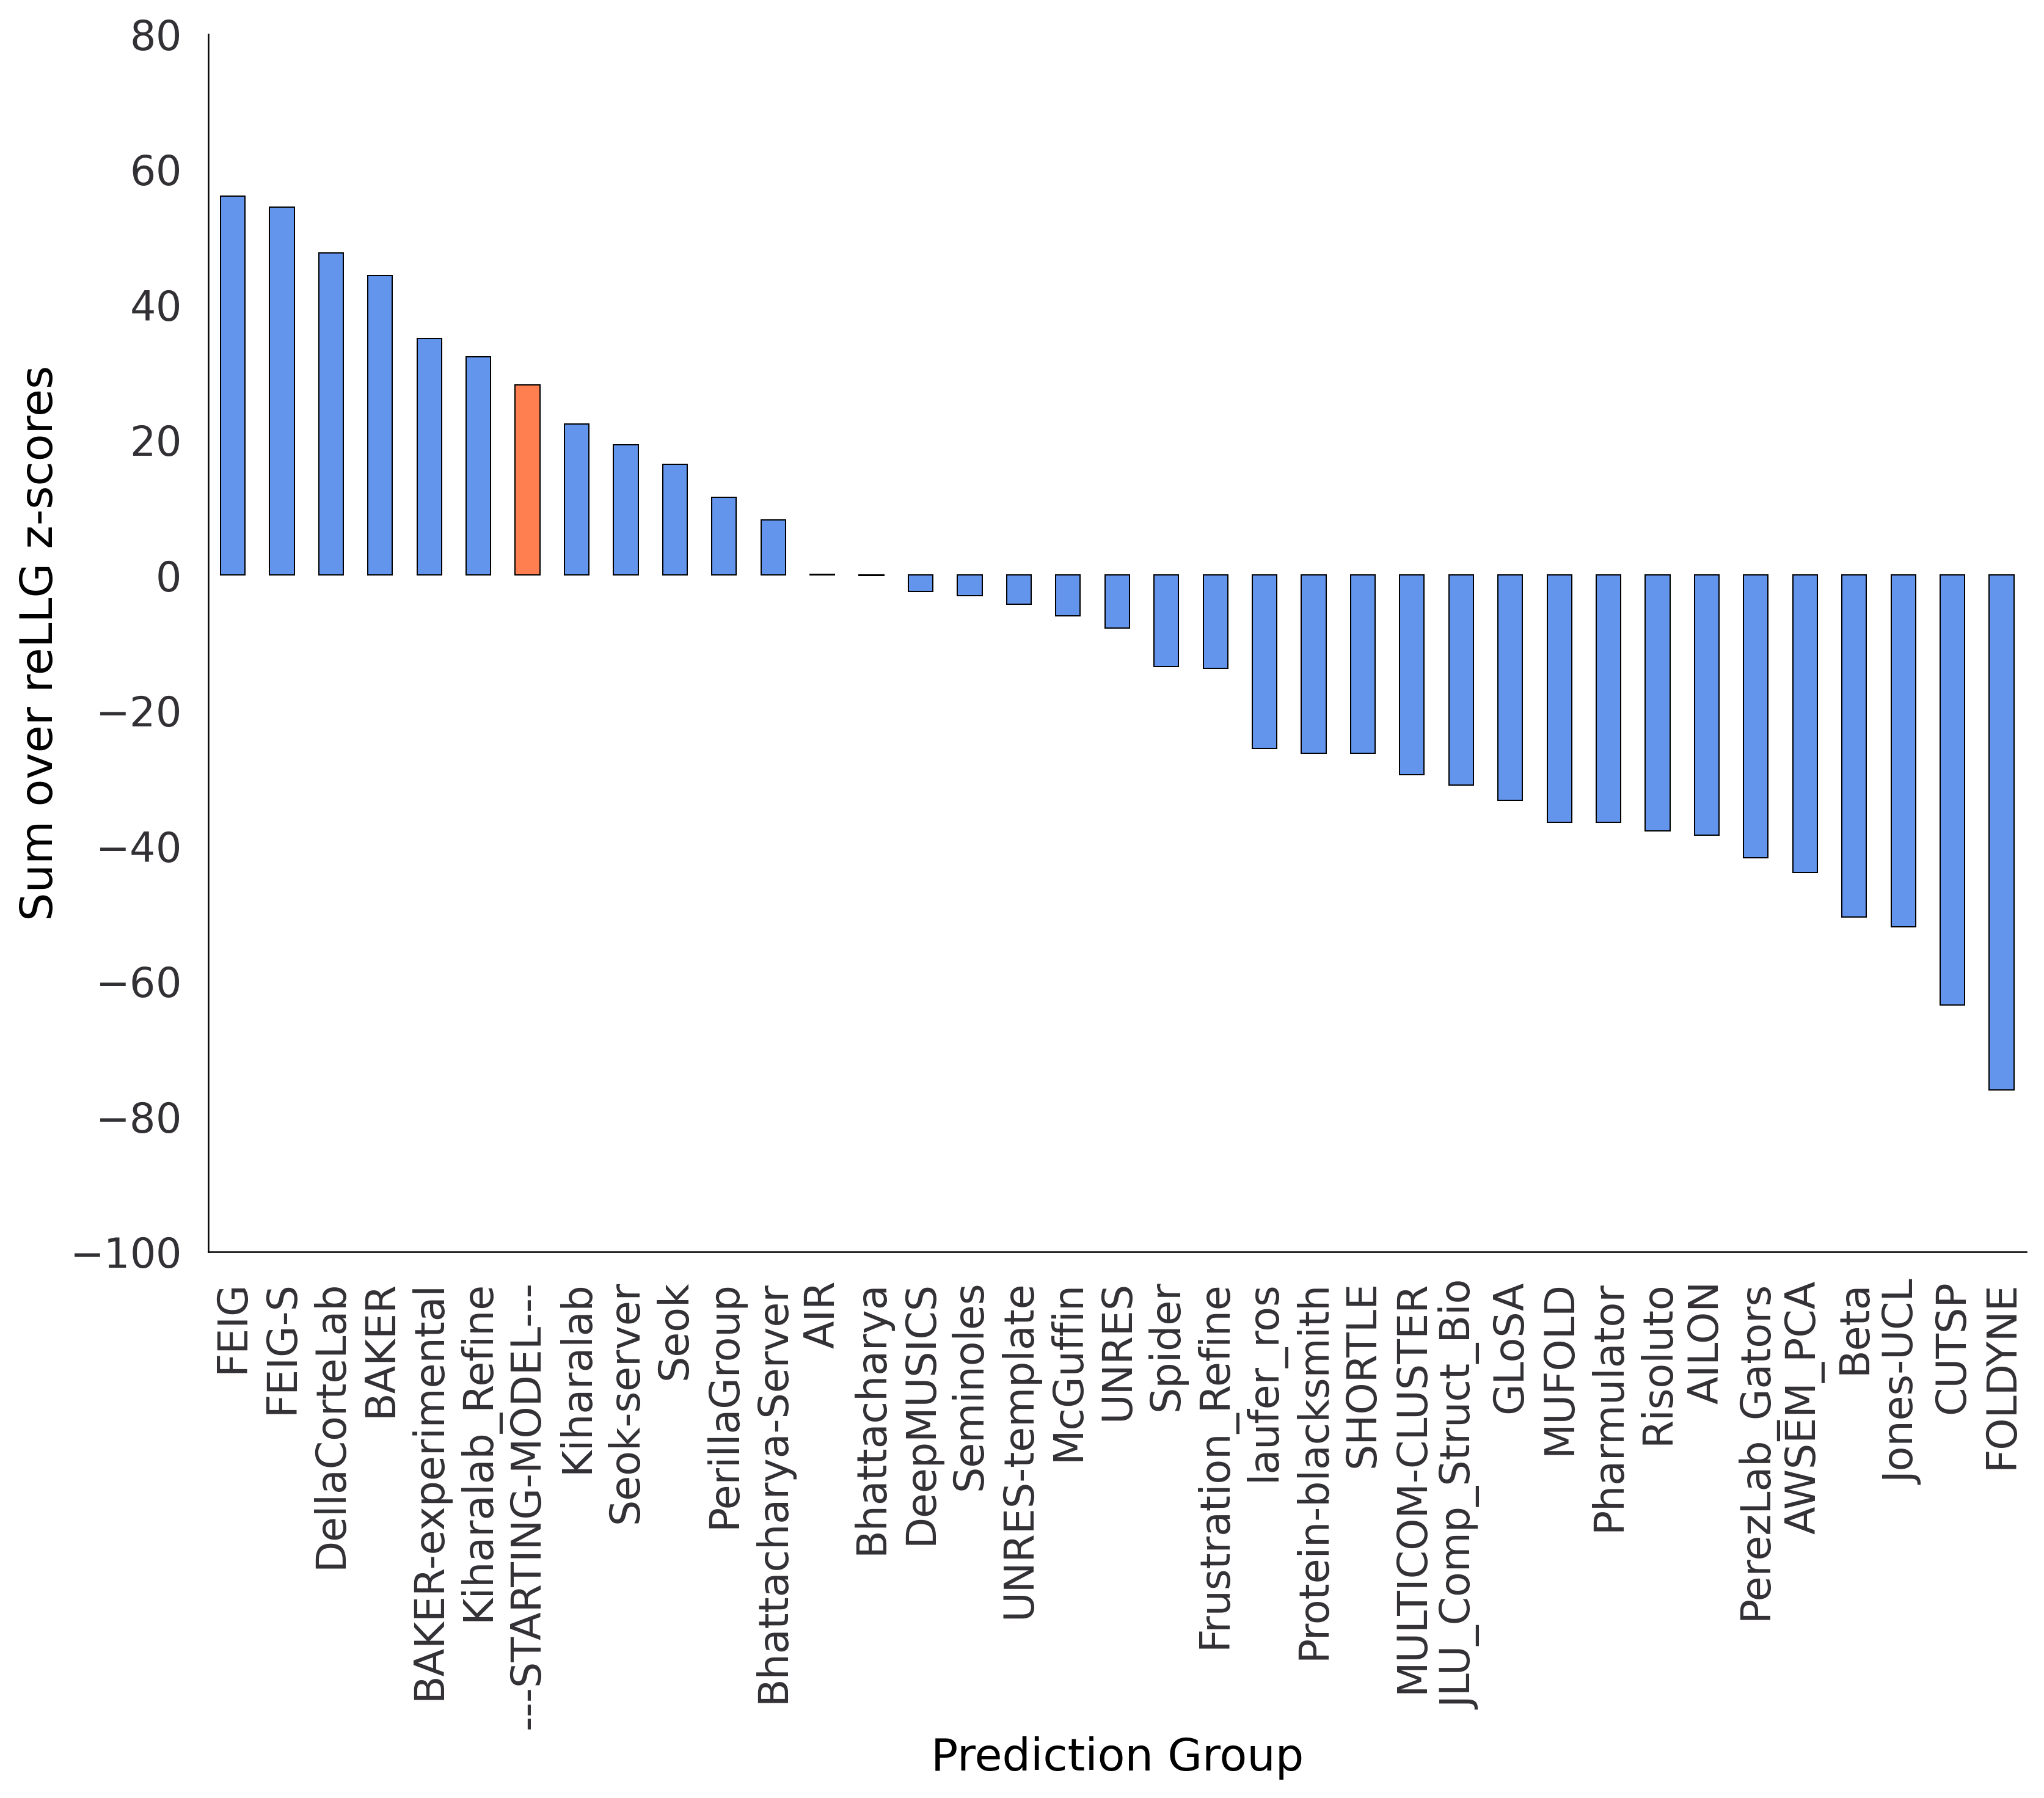

In [ ]:
plt.style.use(['/content/drive/MyDrive/DATA_FOR_NOTEBOOKS/mydefplot.mplstyle','seaborn-poster'])
plt.rcParams['font.family'] = 'Arial'

# Now rank the groups

df_mod1 =  df_all.copy(deep=True) # df_all now has already only model 1
#display(df_mod1)


#print('SHERLOCK LEN DFMOD1 BEFORE',len(df_mod1))
# Also, substitute the values of the starting models by those of the bfactor constant
# My idea, possibly not optimal
# First, remove all the starting model values from the as_rmsd 
df_mod1_noref =  (df_mod1.loc[df_mod1['Group']!='999']).copy(deep=True)
#display(df_mod1_noref)
# Now, alter the dataframe from the previous cell and change the column names so that the reLLG_bfactor_constant is named like the as_rmsd
#display(merge_to_compare)
# Drop the duplicated columns with the y
# Our target headers at the end are: Model	reLLG_as_rmsd	Target_Evaluation	Target	Self_rank	Group	reLLG_as_rmsd_zscore	Name_Group	Has_Exp_Data
merge_to_compare_1 = merge_to_compare.loc[:,~merge_to_compare.columns.str.endswith('y')]
#display(merge_to_compare_1)
merge_to_compare_2 = merge_to_compare_1.rename(columns={'Target_Evaluation_x':'Target_Evaluation','Target_x':'Target','Self_rank_x':'Self_rank','Group_x':'Group','Name_Group_x':'Name_Group','Has_Exp_Data_x':'Has_Exp_Data'},inplace=False)
merge_to_compare_3 = merge_to_compare_2.rename(columns = {'reLLG_bfactor_constant':'reLLG_as_rmsd','reLLG_bfactor_constant':'old_rellg_constant','reLLG_bfactor_constant_zscore':'reLLG_as_rmsd_zscore','reLLG_bfactor_constant_zscore':'old_rellg_constant_zscore'}, inplace = False)
#display(merge_to_compare_3)
merge_to_compare_3.drop(columns=['old_rellg_constant','old_rellg_constant_zscore'],inplace=True)
#display(merge_to_compare_3)
#print('SHERLOCK LEN MERGE TO COMPARE',len(merge_to_compare_3))
# Then concatenate it with the as_rmsd before doing the rankings
full_merge = pd.concat([df_mod1_noref,merge_to_compare_3])
#display(full_merge)


temp_data = full_merge.copy(deep=True)

def include_penalization(dati,treatment,list_target_evaluation):
  print("BEFORE ADDING PENALIZATION",len(dati))
  list_dataframes_to_concat = []
  by_groups = dati.groupby(['Name_Group'])
  for group in by_groups:
    #print("\n\nChecking targets evaluated for group  ",group[0])
    targets_evaluated_by_group = group[1]['Target_Evaluation'].unique() 
    #print("Targets evaluated by this group are ",len(targets_evaluated_by_group))
    #print(targets_evaluated_by_group)
    diff = set(list_target_evaluation)-set(targets_evaluated_by_group)
    if len(diff) > 0:
      #print("Diff is ",diff)
      #print("This group did not predict the targets:")
      # we then need to add a row per each target not evaluated
      new_df = group[1].copy(deep=True)
      #print("SHERLOCK NEW_DF")
      #display(new_df)
      for not_evaluated in diff:
        if 'x' in not_evaluated:
            #print("\nThis is an extended target")
            #print(not_evaluated)
            # Check if the non-extended version is there
            #print("SHERLOCK (not_evaluated[:5]",(not_evaluated[:5]))
            true_df = new_df.loc[new_df['Model'].str.startswith(not_evaluated[:5]) & ~new_df["Model"].str.contains('v')]
            if len(true_df) == 1: # we know there is a hit for which we need to extract the z-score
                zscore_not_extended = (true_df['reLLG_'+treatment+'_zscore'].values)[0]
                score_not_extended = (true_df['reLLG_'+treatment].values)[0]
                #Model	reLLG_as_rmsd	Target_Evaluation	Target	Self_rank	Group	reLLG_as_rmsd_zscore	Name_Group	Has_Exp_Data
                new_df = new_df.append({'Model': "dummy"+str(not_evaluated),"reLLG_"+treatment:score_not_extended,"Target_Evaluation":not_evaluated,"Target":not_evaluated[:5],"Self_rank":1,"Group":"None","reLLG_"+treatment+"_zscore":zscore_not_extended, "Name_Group":group[0],"Has_Exp_Data":False},ignore_index=True)
        else:
            #print("\nThis is NOT an extended target")
            #Model	reLLG_as_rmsd	Target_Evaluation	Target	Self_rank	Group	reLLG_as_rmsd_zscore	Name_Group	Has_Exp_Data
            new_df = new_df.append({'Model': "dummy"+str(not_evaluated),"reLLG_"+treatment:0,"Target_Evaluation":not_evaluated,"Target":not_evaluated[:5],"Self_rank":1,"Group":"None","reLLG_"+treatment+"_zscore":-2, "Name_Group":group[0],"Has_Exp_Data":False},ignore_index=True)
      #print("AFTER")
      #display(new_df)
      list_dataframes_to_concat.append(new_df)
      #break
    else: # we will concatenate as it is
      same_df = group[1].copy(deep=True)
      #display(same_df)
      list_dataframes_to_concat.append(same_df)
      #break
  concatenated = pd.concat(list_dataframes_to_concat)
  print("AFTER ADDING PENALIZATION",len(concatenated))
  #display(concatenated)
  return concatenated

print("BEFORE PENALIZATION ")
#display(temp_data)
with_penalization = include_penalization(temp_data,'as_rmsd',list_target_evaluation)
#display(with_penalization)


df_mod1 = with_penalization.copy(deep=True)

# 1.2.1. Using sum values
# 1.2.1.2 On the zscore
rank_model_1_as_rmsd_zscore_sum = df_mod1.groupby(['Name_Group'])['reLLG_as_rmsd_zscore'].sum()
rank_model_1_as_rmsd_zscore_sum.sort_values(inplace=True,ascending=False)
list_colour=get_list_color_ref(rank_model_1_as_rmsd_zscore_sum)
#print("\n\nBelow ranking using summatories over zscore of the metric")
##print(rank_model_1_as_rmsd_zscore_sum)
plot_rank_model1_as_rmsd_zscore_sum = rank_model_1_as_rmsd_zscore_sum.plot.bar(color=list_colour)
plot_rank_model1_as_rmsd_zscore_sum.set_xlabel("Prediction Group")
plot_rank_model1_as_rmsd_zscore_sum.set_ylabel("Sum over reLLG z-scores")
plt.show()


# Check the double barreled targets
#check_models = df_mod1.loc[df_mod1["Model"].str.contains('v') & df_mod1['Model'].str.startswith('R1074v2') & ~df_mod1["Model"].str.startswith('dummy')]
#check_models.sort_values(by='reLLG_as_rmsd',inplace=True,ascending=False)
#display(check_models)

BEFORE ADDING PENALIZATION 1408
AFTER ADDING PENALIZATION 1607


,reLLG_as_rmsd,reLLG_bfactor_constant,Difference
Name_Group,,,
AILON,0.050255,0.204639,-0.154384
AIR,0.948372,0.948365,0.000007
AWSEM_PCA,0.004573,0.360028,-0.355455
BAKER,2.110205,1.618058,0.492146
BAKER-experimental,1.789199,1.247208,0.541991
Beta,0.005287,0.306247,-0.300960
Bhattacharya,0.846455,1.133517,-0.287062
Bhattacharya-Server,1.228719,1.081899,0.146820
CUTSP,0.001801,0.001793,0.000007


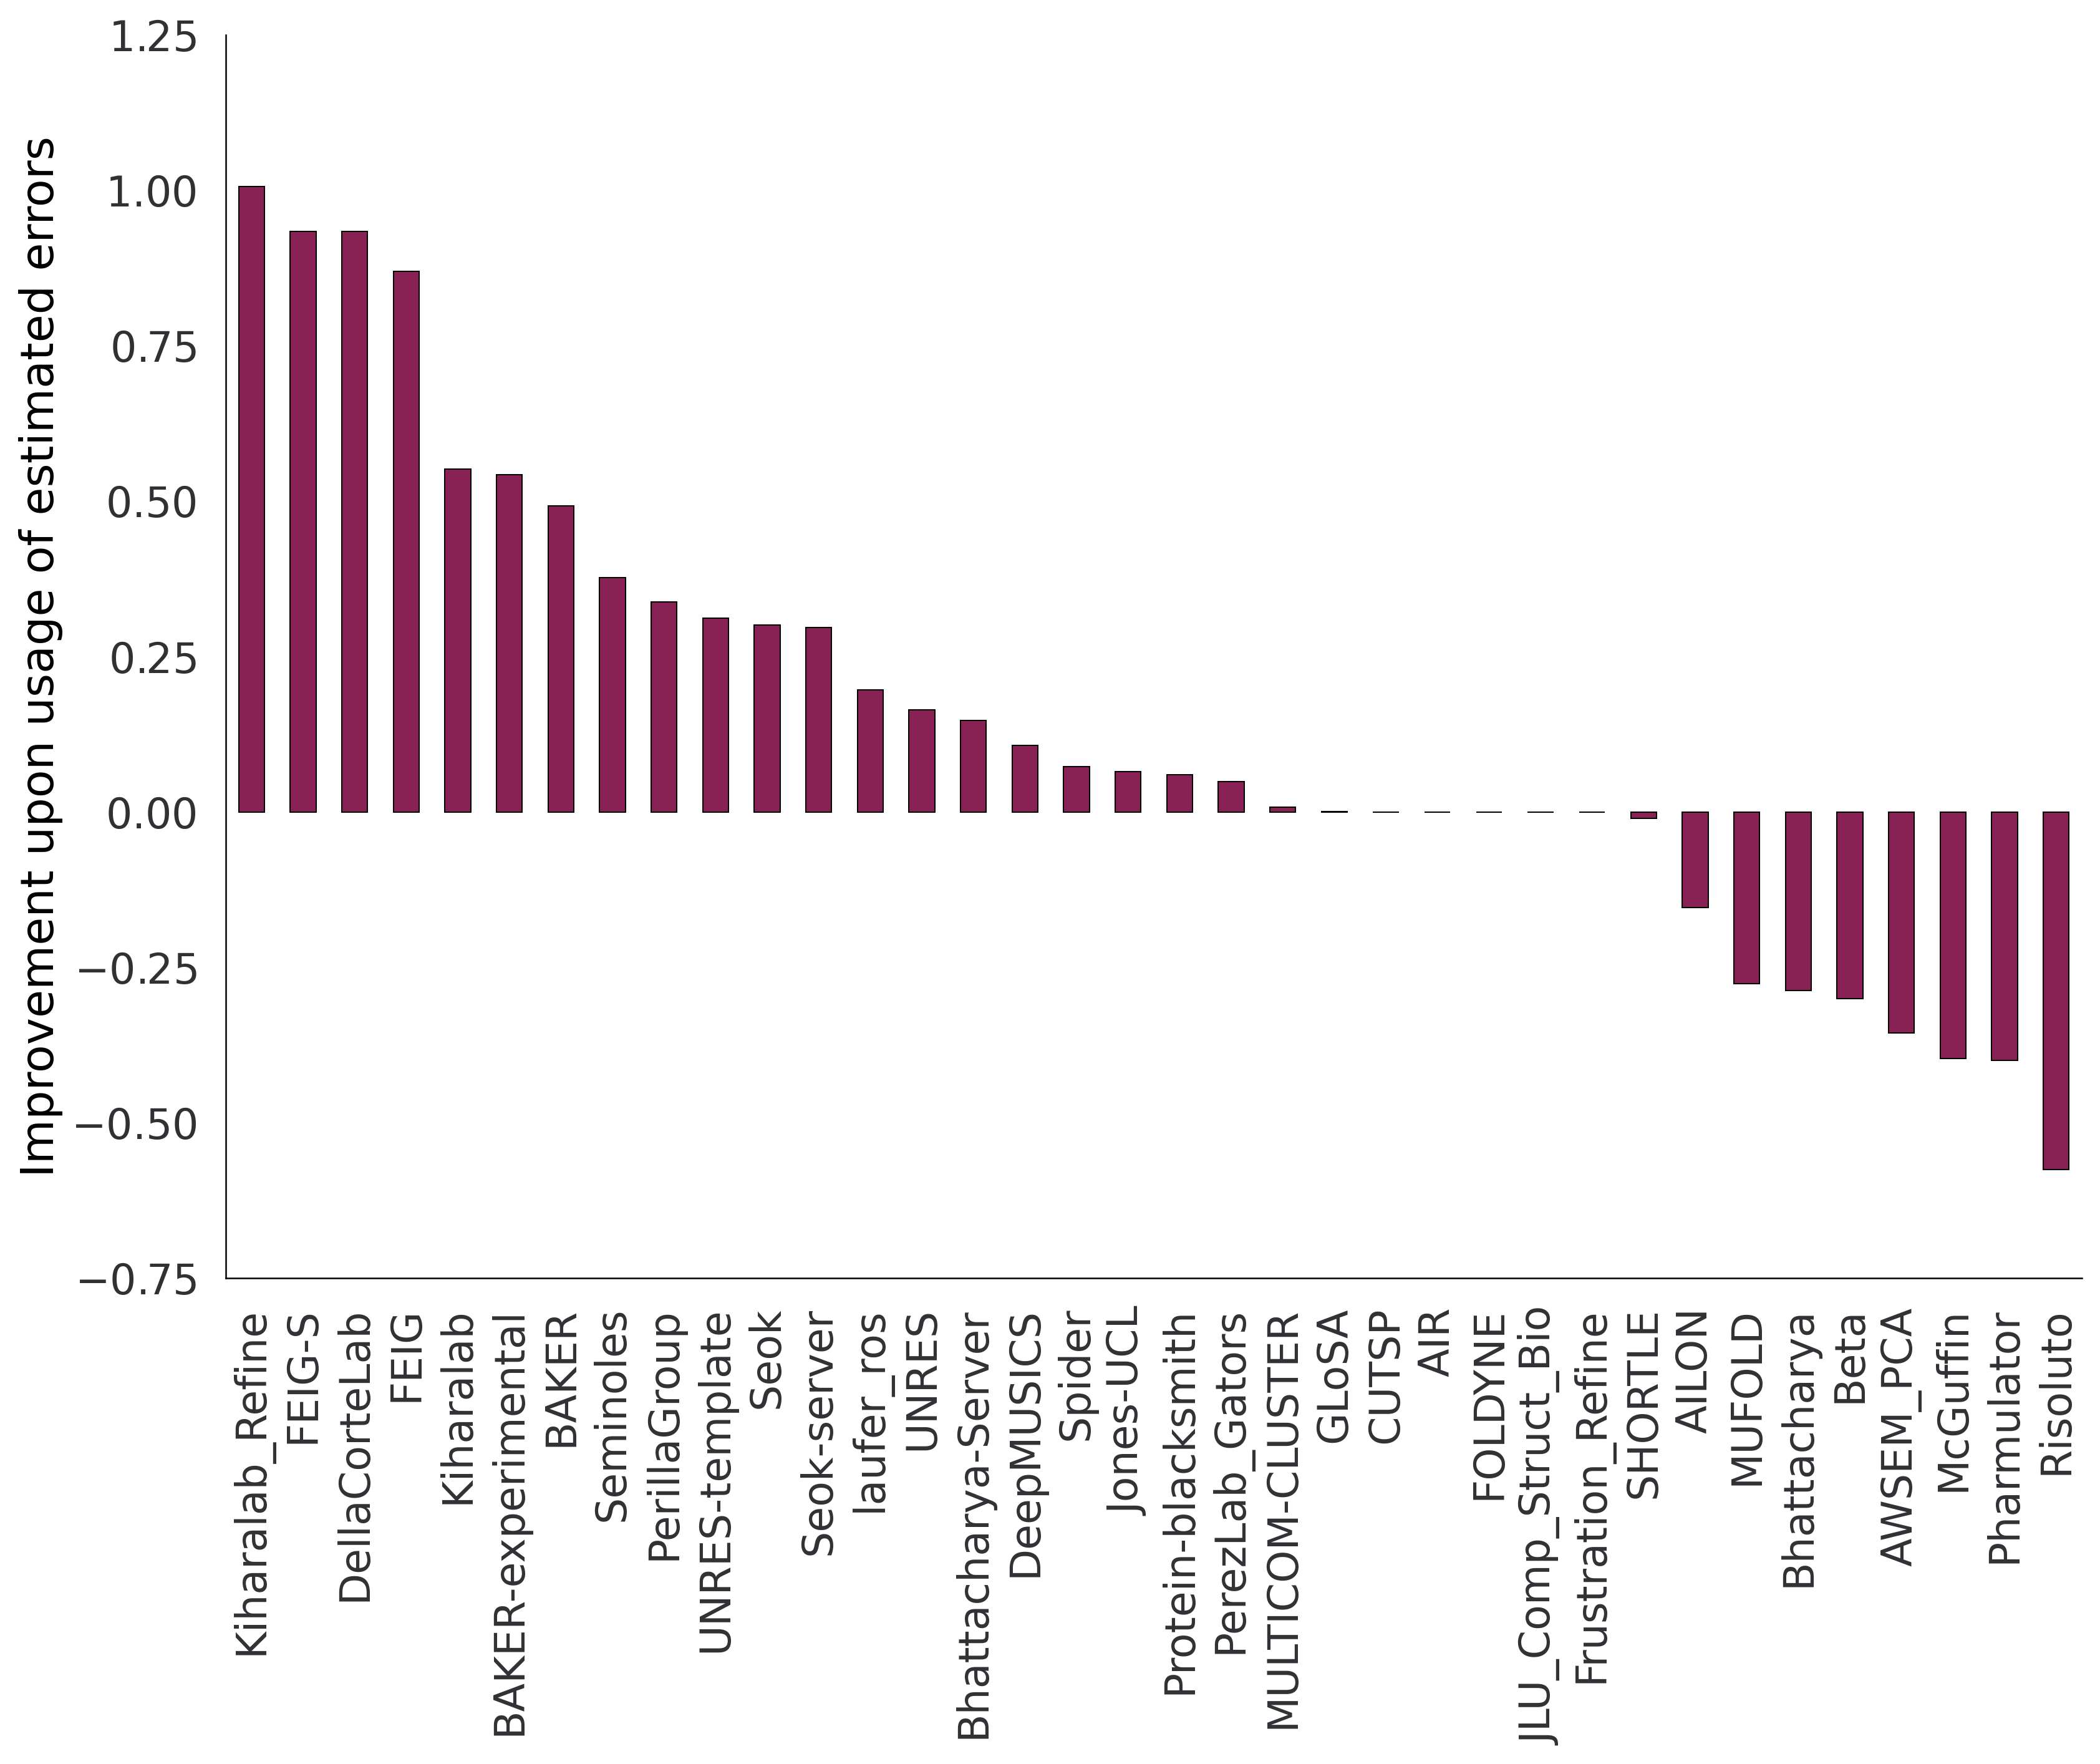

In [ ]:
# Check the improvement that adding error estimations makes:

# Now compare in a plot bar how better they did in terms of comparing raw coordinates to raw coordinates and error estimations

plt.style.use(['/content/drive/MyDrive/DATA_FOR_NOTEBOOKS/mydefplot.mplstyle','seaborn-poster'])
plt.rcParams['font.family'] = 'Arial'

# df_mod1 is the one from rmsd and also has the penalizations already
#display(df_mod1)
# for the bfactor we need to apply the same
# df_all_targets_bfacconst_merged --> this is the full one, it already has only the model 1
temp_data = df_all_targets_bfacconst_merged.copy(deep=True)
with_penalization = include_penalization(temp_data,'bfactor_constant',list_target_evaluation)
#display(with_penalization)
df_mod1_bfac_const = with_penalization.copy(deep=True)
#display(df_mod1_bfac_const)

# Remove the starting model it does not make sense that we consider it for this difference
df_mod1_noref = df_mod1.loc[df_mod1['Name_Group']!="---STARTING-MODEL---"]
df_mod1_bfac_const_noref = df_mod1_bfac_const.loc[df_mod1_bfac_const['Name_Group']!="---STARTING-MODEL---"]
as_rmsd_by_group = df_mod1_noref.groupby(['Name_Group'])['reLLG_as_rmsd'].sum()
constant_by_group = df_mod1_bfac_const_noref.groupby(['Name_Group'])['reLLG_bfactor_constant'].sum()
#display(as_rmsd_by_group)
#display(constant_by_group)

merged_df = pd.merge(as_rmsd_by_group,constant_by_group,right_index = True,left_index = True)


# Plot with the two bars [it will not work if the dataframe as the new column difference]
#ax = merged_df.plot.bar(rot=0, title="Comparison between raw coordinates and estimated error",figsize=(40,10))
#ax.set_xlabel("Groups")
#ax.set_ylabel("Sum over reLLG")
#plt.xticks(rotation=90)
#ax.figure.savefig("Comparison_between_raw_coordinates_and_estimated_error_prediction.png",figsize=(40,10),bbox_inches = "tight")
#files.download("Comparison_between_raw_coordinates_and_estimated_error_prediction.png") # This will download it
#plt.show()

merged_df['Difference'] = merged_df['reLLG_as_rmsd'] - merged_df['reLLG_bfactor_constant']
display(merged_df)

# Commenting to see if more informative with all the groups

"""
# Get the groups corresponding to the best 20 from as rmsd and from the best 20 from bfactor constant
print("Best ones from as_rmsd")
top20rmsd_df = merged_df.nlargest(20,'reLLG_as_rmsd')
top20rmsd = top20rmsd_df.index.values.tolist()
print(top20rmsd)
print("Best ones from bfactor constant")
top20cons_df = merged_df.nlargest(20,'reLLG_bfactor_constant')
top20cons = top20cons_df.index.values.tolist()
print(top20cons)
unique_top = (set(top20rmsd)).union(set(top20cons))
print("Union is ",unique_top)
print("len of union is ",len(unique_top))
unique_list = list(unique_top)
# Filter by this top
merged_df  = merged_df[merged_df.index.isin(unique_list)]
"""


# Plot with the difference
merged_df.sort_values('Difference', ascending=False, inplace=True)
ax = merged_df['Difference'].plot.bar(rot=0,color='#882255')
ax.set_xlabel("")
ax.set_ylabel("Improvement upon usage of estimated errors")
plt.xticks(rotation=90)
#ax.figure.savefig("Comparison_between_raw_coordinates_and_estimated_error_prediction_difference.png",figsize=(40,10),bbox_inches = "tight")
#files.download("Comparison_between_raw_coordinates_and_estimated_error_prediction_difference.png") # This will download it
plt.show()


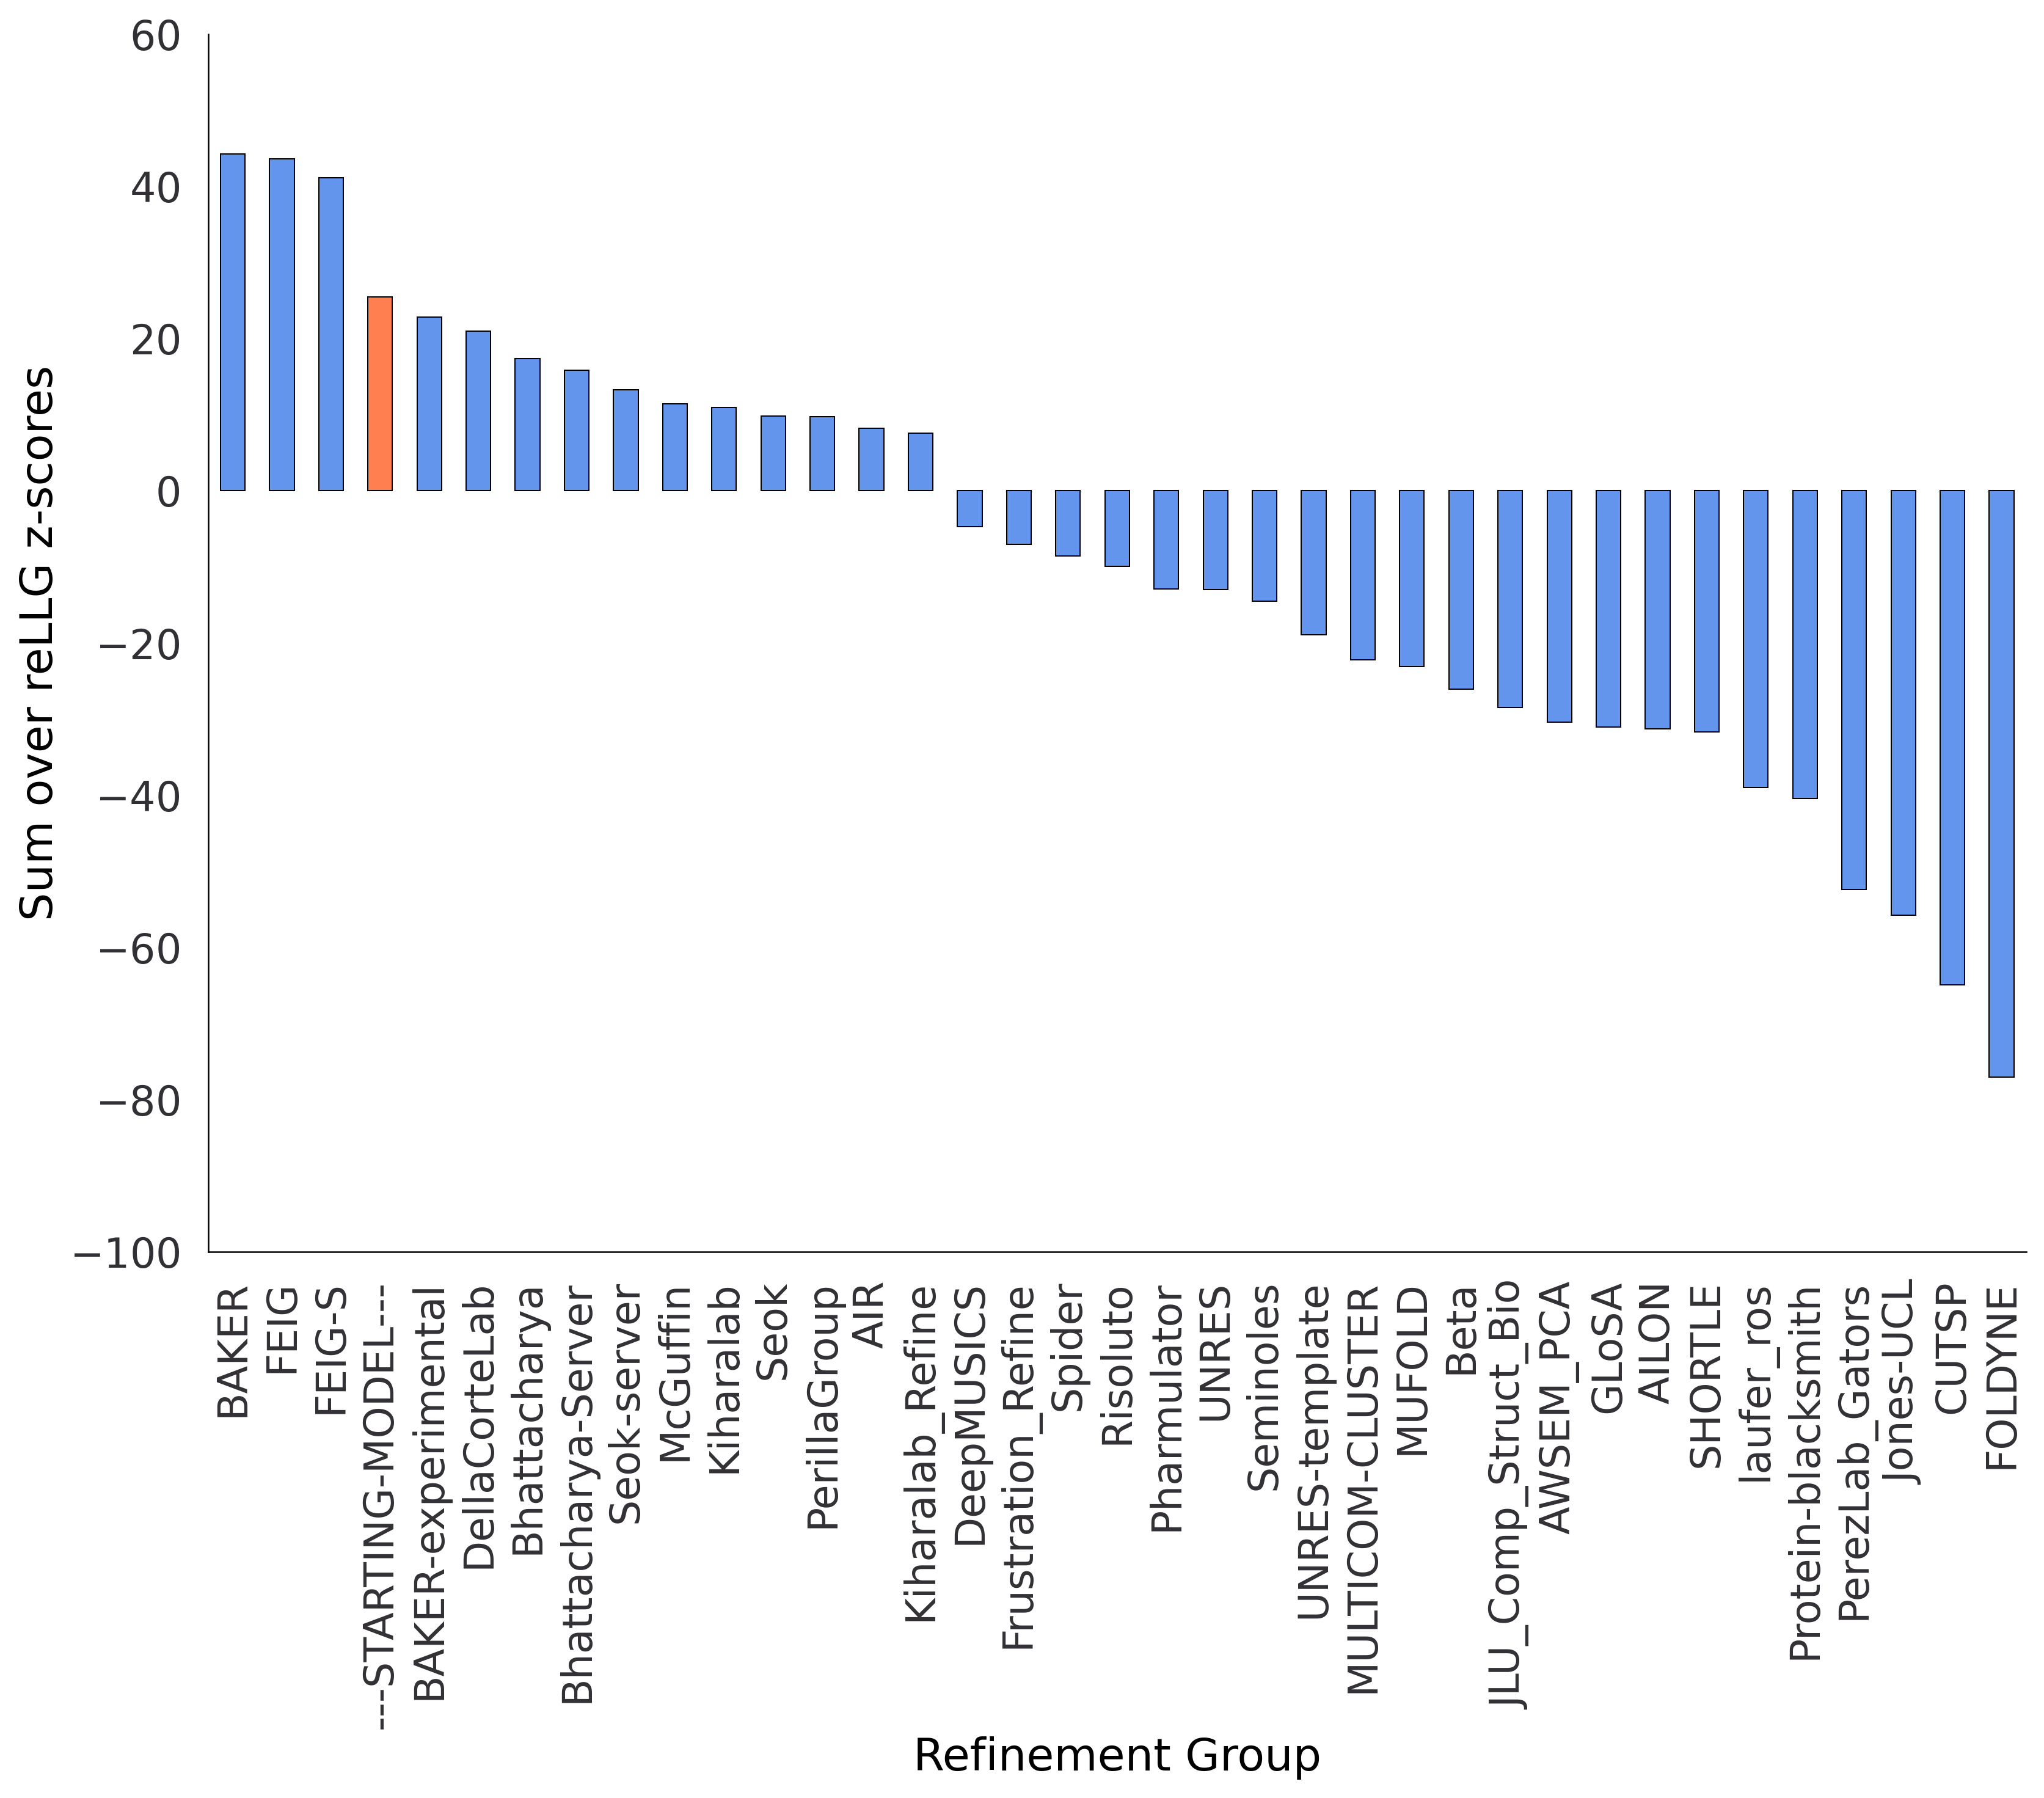

In [ ]:
# Just for exploration, do the overall ranking but over the values of the bfactor constant
#display(df_mod1_bfac_const)
rank_model_1_bcons_zscore_sum = df_mod1_bfac_const.groupby(['Name_Group'])['reLLG_bfactor_constant_zscore'].sum()
rank_model_1_bcons_zscore_sum.sort_values(inplace=True,ascending=False)
list_colour=get_list_color_ref(rank_model_1_bcons_zscore_sum)
#print("\n\nBelow ranking using summatories over zscore of the metric")
##print(rank_model_1_bcons_zscore_sum)
plot_rank_model1_bcons_zscore_sum = rank_model_1_bcons_zscore_sum.plot.bar(color=list_colour)
plot_rank_model1_bcons_zscore_sum.set_xlabel("Refinement Group")
plot_rank_model1_bcons_zscore_sum.set_ylabel("Sum over reLLG z-scores")
plt.show()

,Model,reLLG_as_rmsd,Target_Evaluation,Target,Self_rank,Group,reLLG_as_rmsd_zscore,Name_Group,Has_Exp_Data
0,R1052-D2TS003_1,0.001593,R1052-D2,1052,1,003,-1.370044,SHORTLE,True
1,R1052-D2TS003_2,0.000992,R1052-D2,1052,2,003,-1.452331,SHORTLE,True
2,R1091-D2TS003_1,0.005476,R1091-D2,1091,1,003,-0.742632,SHORTLE,True
3,R1030-D2TS003_1,0.002858,R1030-D2,1030,1,003,-0.308308,SHORTLE,True
4,R1085-D1TS003_1,0.000730,R1085-D1,1085,1,003,-0.322285,SHORTLE,True
...,...,...,...,...,...,...,...,...,...
5858,R1034x1TS080_4,0.020808,R1034x1,1034,4,080,-0.809443,FOLDYNE,True
5859,R1090TS080_1,0.001139,R1090,1090,1,080,-0.563404,FOLDYNE,True
5860,R1090TS080_2,0.001350,R1090,1090,2,080,-0.545211,FOLDYNE,True
5861,R1090TS080_3,0.001428,R1090,1090,3,080,-0.538416,FOLDYNE,True


Correlation below


0.3128367663751208

Dataframe below


,Name_Group,Percentage,Z-score
0,Seok,43.243243,0.152392
1,FEIG-S,43.181818,0.881233
2,BAKER-experimental,43.181818,0.416103
3,MULTICOM-CLUSTER,40.000000,-0.024939
4,Kiharalab,36.363636,0.369168
5,laufer_ros,34.615385,-0.314095
6,PerezLab_Gators,33.333333,-0.692751
7,BAKER,31.818182,0.851976
8,McGuffin,29.729730,-0.134398
9,Kiharalab_Refine,29.545455,0.612197


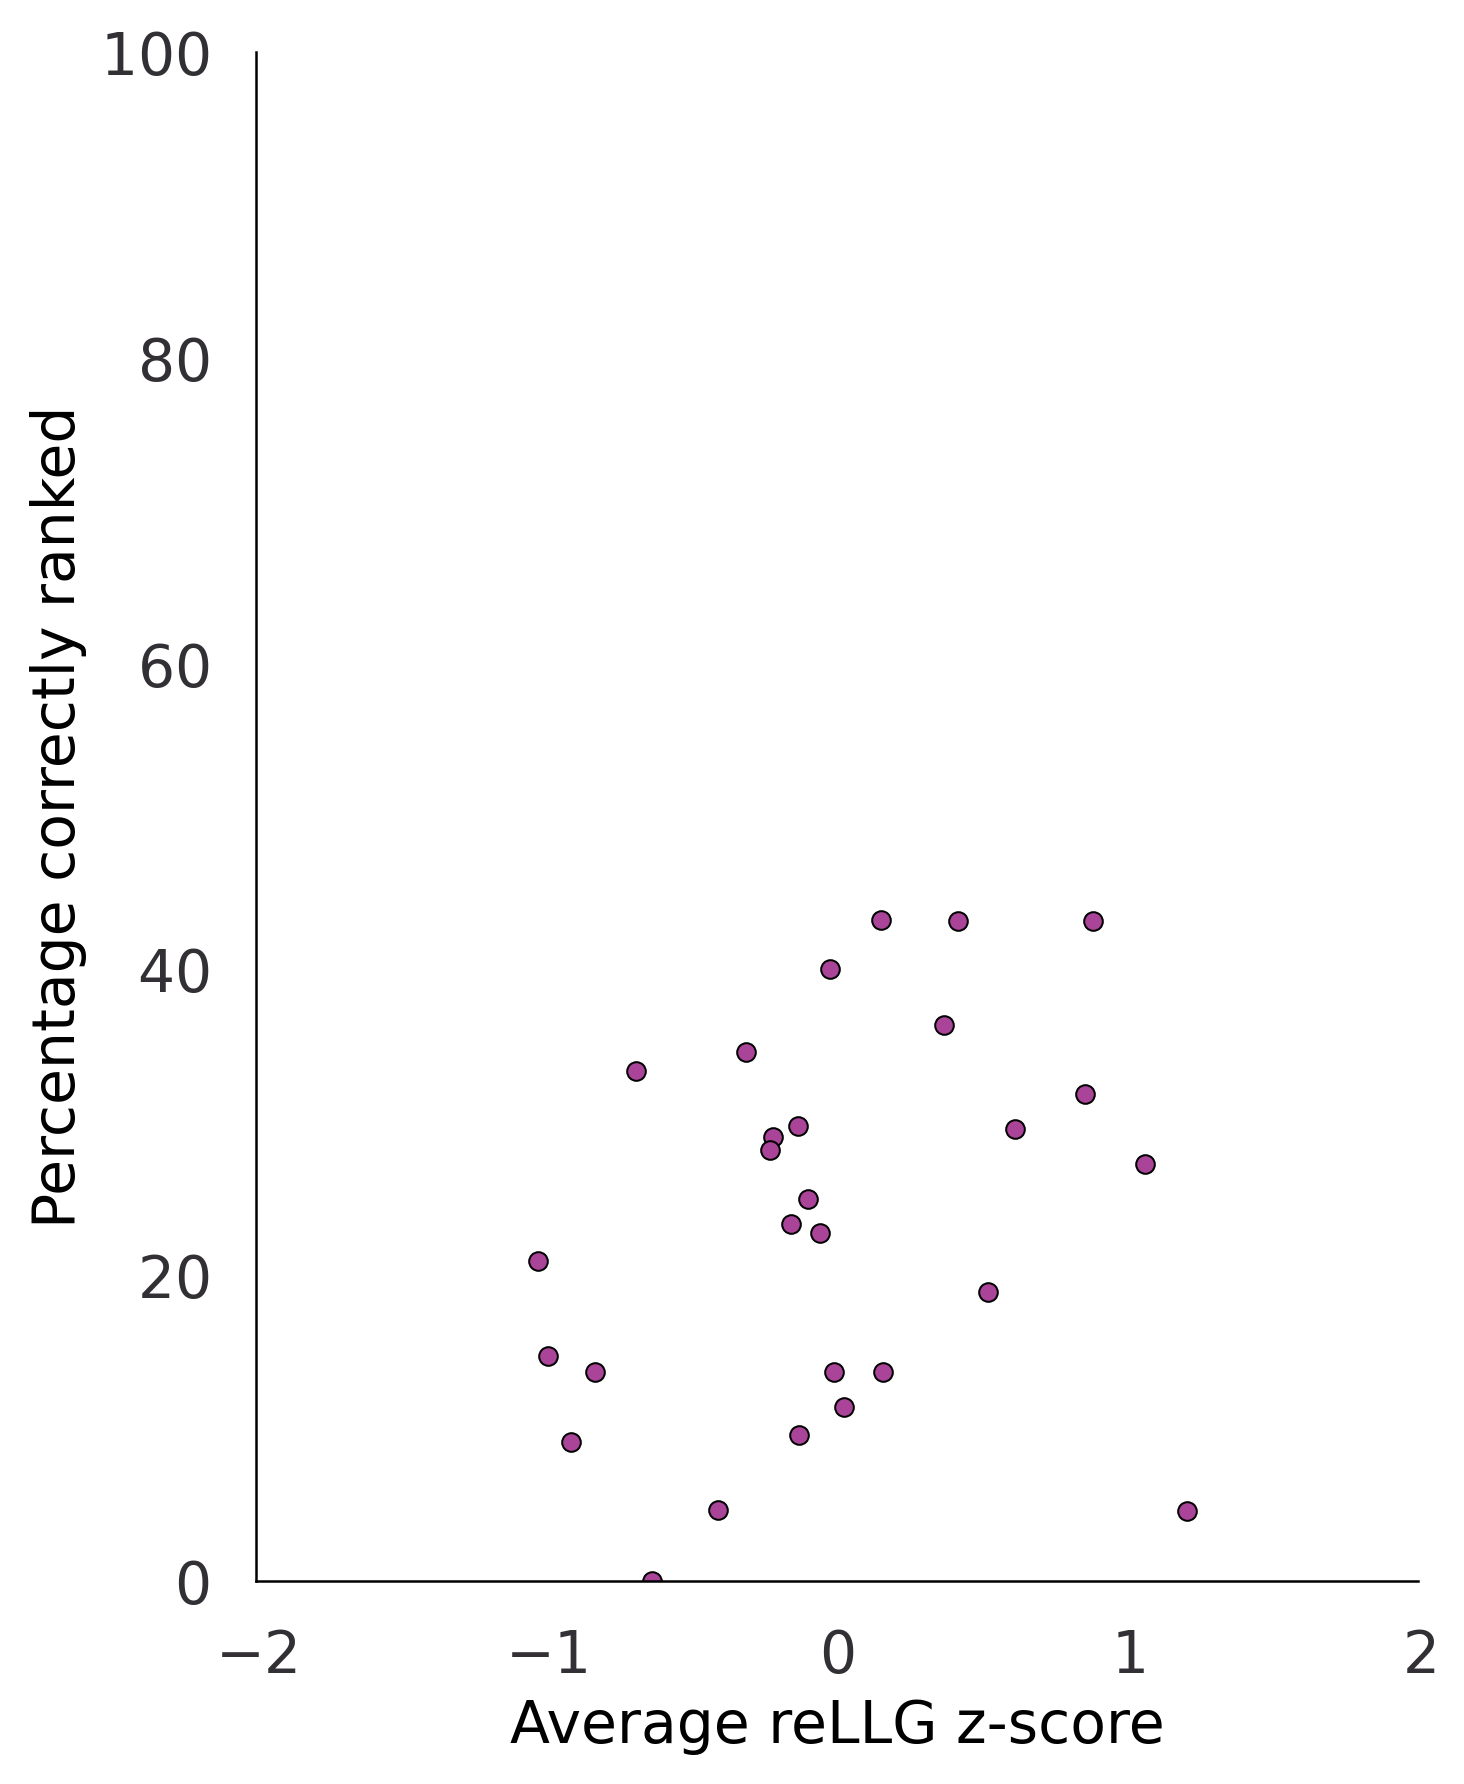

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


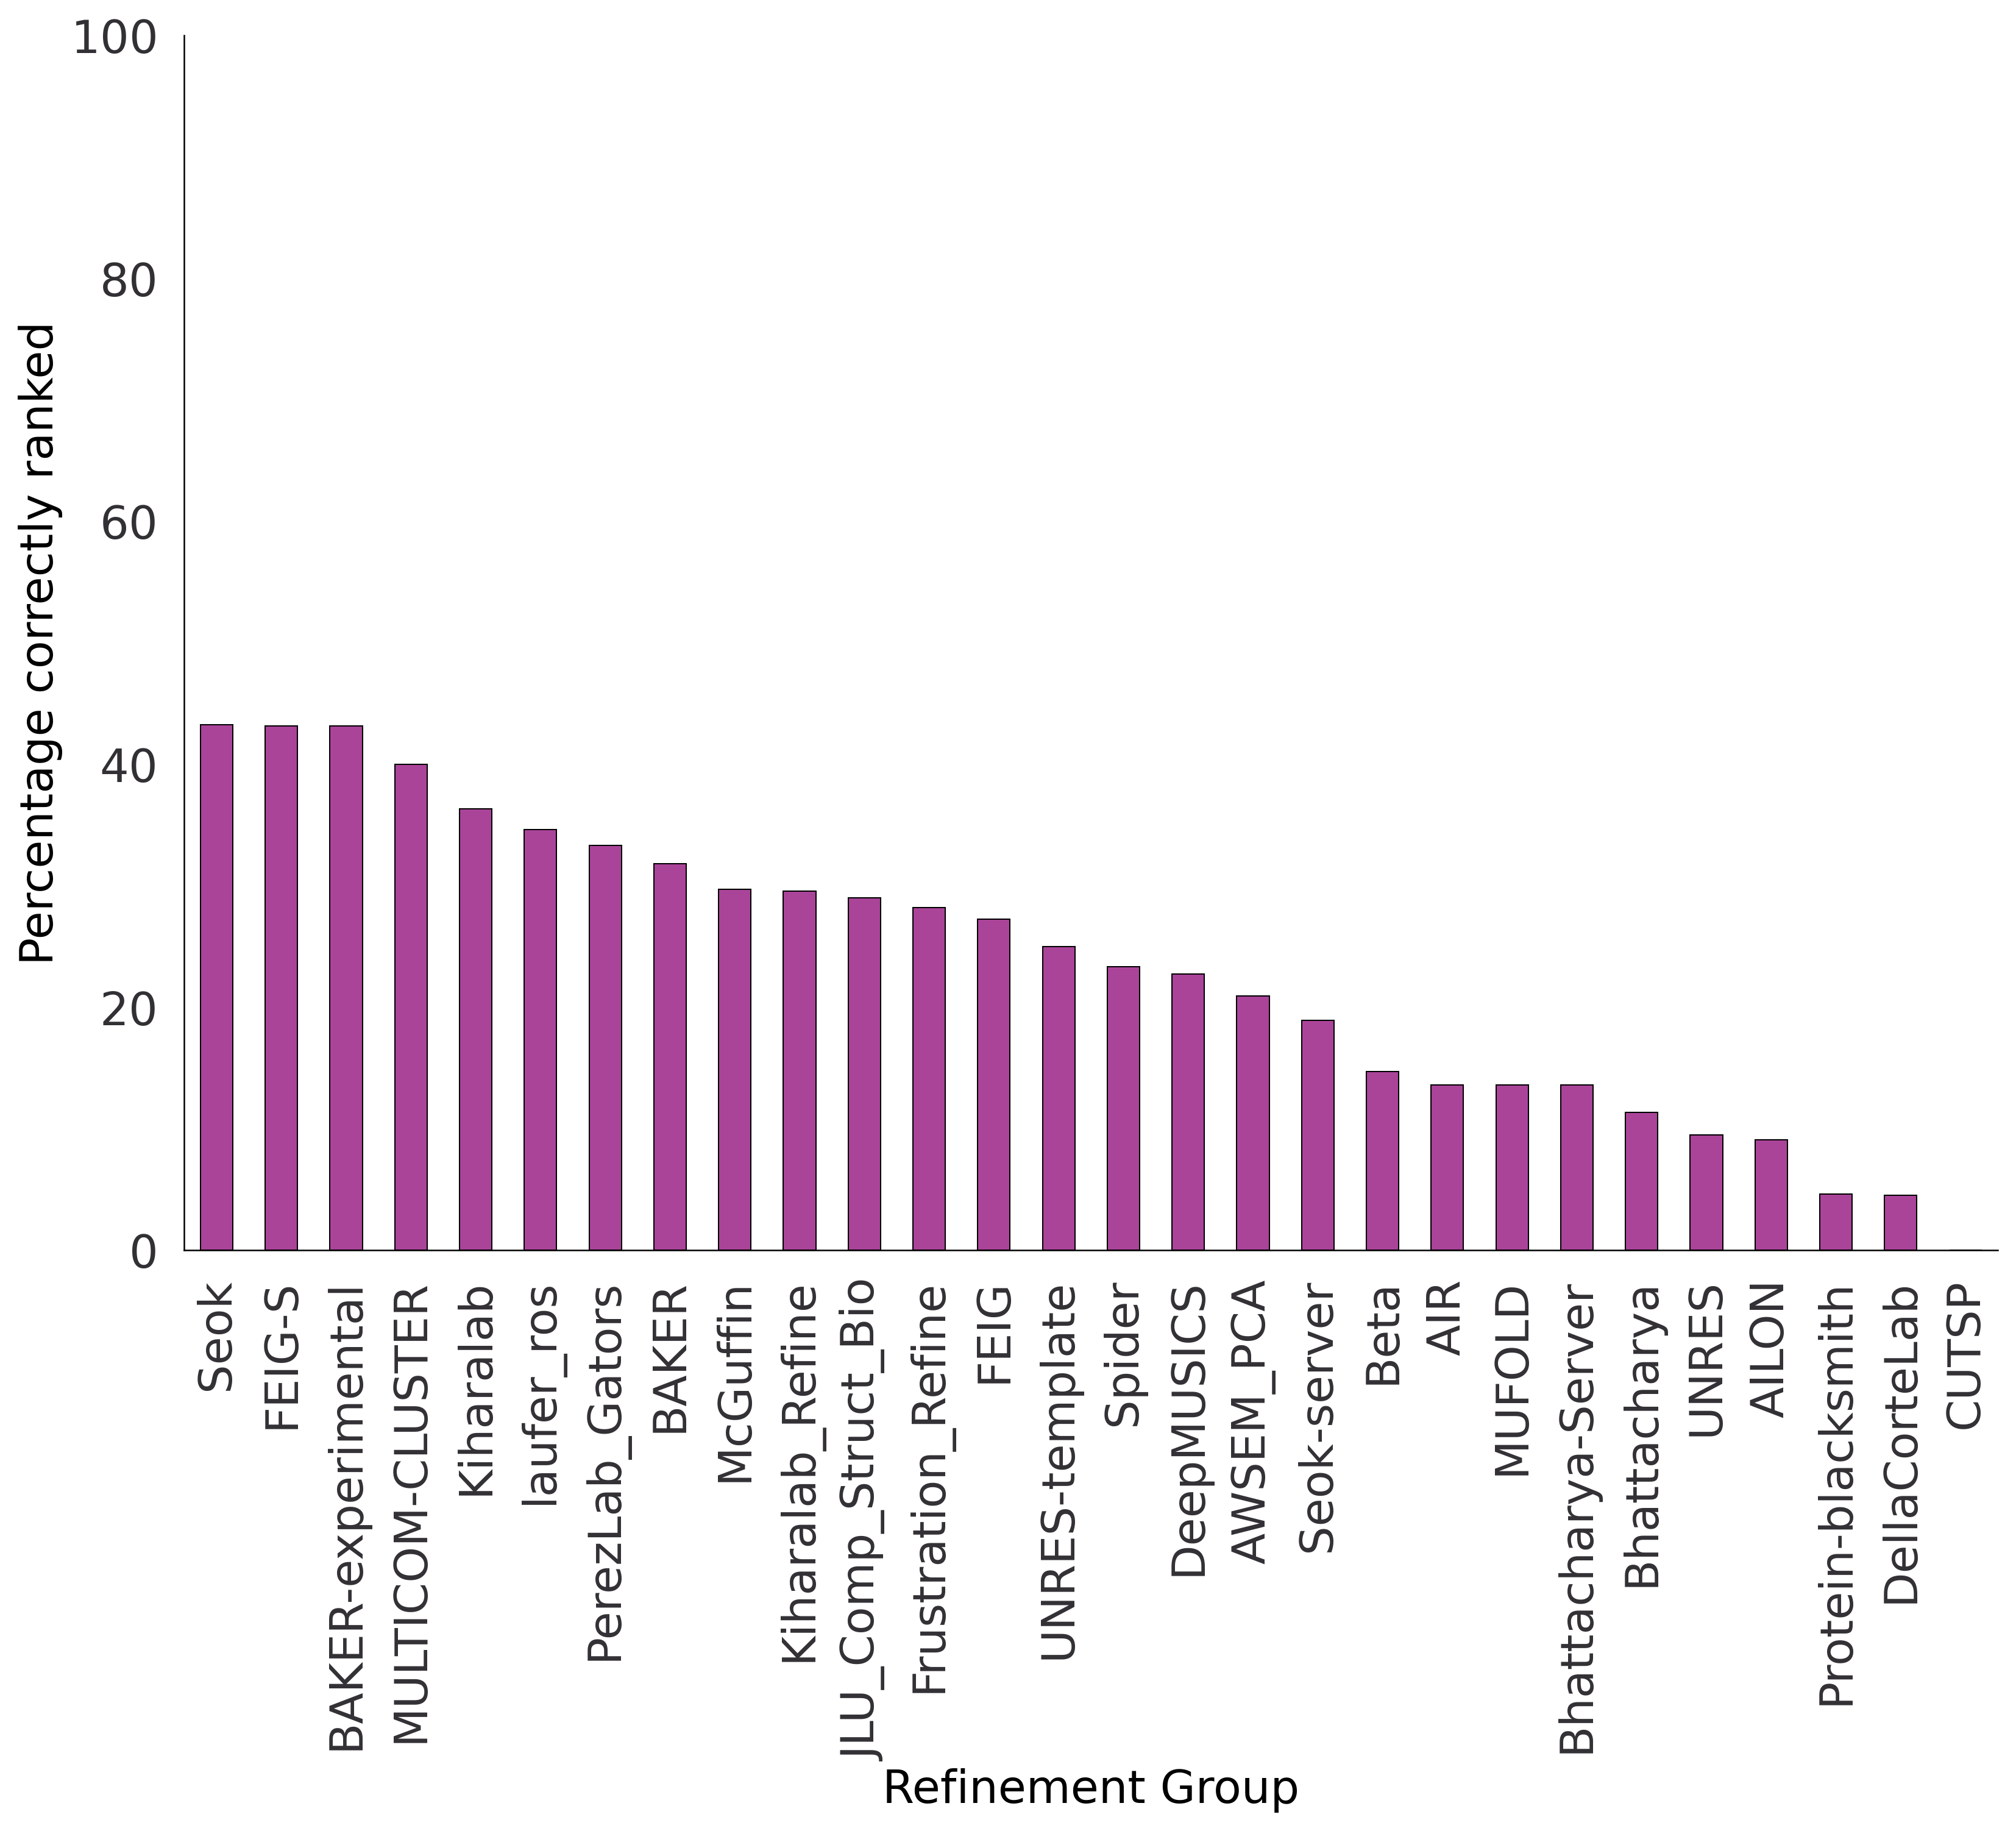

In [ ]:
# 1.3 Can we see if they got their own ranking right?
# Can we see if they got their own ranking right?
# That is, which fraction of their targets were actually right in pointing out model 1 was the best

df_all_targets_and_models = process_all_targets(path_claudia_refinement_tables,treatment='as_rmsd',metric='reLLG',only_first_model=False)
#display(df_all_targets_and_models)
# Include group name and experimental information
# Add the extra information about groups name and availability of x-ray data
df_all_targets_merged = pd.merge(df_all_targets_and_models,df_groups_key,on="Group")
df_all_targets_merged['Has_Exp_Data'] = df_all_targets_merged['Target'].isin(list_xray)
df_all = df_all_targets_merged[numpy.logical_not(df_all_targets_merged['Model'].isin(['R1074v2TS003_1','R1041v2TS003_1', 'R1067v1TS003_1']))]
# This dataframe contains only the models 1 processed and their zscores
display(df_all)

dict_self_rank_correct = {} 
dict_colors = {}
dict_average_zscore = {}
# For this we use the full but remove the starting model
df_models = df_all.loc[df_all['Group']!='999']
#display(df_models)
by_groups = df_models.groupby(['Name_Group'])
for group in by_groups:
  #print("\n\nChecking maximum value for group ",group[0])
  # In each entry we will save in a list 1 per each time their model 1 was actually the best for a given target and 0 when not
  dict_self_rank_correct[group[0]] = []
  # The color will be chosen differently if average value for reLLG is positive or negative
  mean_zscore = group[1]['reLLG_as_rmsd_zscore'].mean()
  dict_average_zscore[group[0]]=mean_zscore
  if mean_zscore < 0:
    dict_colors[group[0]]='lightcoral'
  else:
    dict_colors[group[0]]='palegreen'
  # I can iterate now by each target for this group and see their 5 models
  by_target = group[1].groupby('Target_Evaluation')
  for targeti in by_target:
    #print('\n\n',targeti)
    #print('sherlock len models' ,len(targeti[1]))
    if len(targeti[1])==5:
        # Now get the best score for all their models for that target
        #print('maximum is ',targeti[1]['reLLG_as_rmsd_zscore'].max())
        index_max = targeti[1]['reLLG_as_rmsd_zscore'].idxmax()
        #print(targeti[1].loc[index_max]['Self_rank'])
        if targeti[1].loc[index_max]['Self_rank'] == '1':
            dict_self_rank_correct[group[0]].append(1)
        else:
            dict_self_rank_correct[group[0]].append(0)
    else: 
        # You skip this target because it did not have 5 models
        continue



rank_list = []
for keygroup in dict_self_rank_correct.keys():
  #print("SHERLOCK dict_self_rank_correct[keygroup]",dict_self_rank_correct[keygroup])
  #print("SHERLOCK len(dict_self_rank_correct[keygroup])",len(dict_self_rank_correct[keygroup]))
  total = len(dict_self_rank_correct[keygroup])
  if total > 0:
      positives = dict_self_rank_correct[keygroup].count(1) # how many times was the first
      percentage = (positives * 100) / total
      #print('\nGroup ',keygroup,' had ',positives,' out of ',total,' targets with 5 models correctly ranked as first, giving a % of ',percentage)
      rank_list.append((keygroup,percentage))
  else:
    continue


#print(rank_list)
df_for_plot = pd.DataFrame(rank_list, columns =['Name_Group', 'Percentage'])
df_for_plot.sort_values(by=['Percentage'],ascending=False,inplace=True)
#df_for_plot.index = df_for_plot['Group']
#display(df_for_plot)


# Now do a scatter plot
df_zscore = pd.DataFrame.from_dict(dict_average_zscore,orient='index')
df_zscore['Group'] = df_zscore.index
df_zscore.columns=['Z-score','Name_Group']
#display(df_zscore)



merge_for_scatter = pd.merge(df_for_plot,df_zscore,on='Name_Group')
# also compute the correlation between those two columns
print("Correlation below")
display(merge_for_scatter['Z-score'].corr(merge_for_scatter['Percentage']))
print("Dataframe below")
display(merge_for_scatter)
ax = merge_for_scatter.plot.scatter(x="Z-score",y="Percentage",color="#AA4499",figsize=(5,6.75),s=20,fontsize=14)
ax.set_xlabel("Average reLLG z-score",fontsize=14)
ax.set_ylabel("Percentage correctly ranked",fontsize=14)
plt.ylim(0,100)
plt.show()

# And also a bar plot with only the top20
#display(rank_model_1_as_rmsd_zscore_sum)
#top20only = rank_model_1_as_rmsd_zscore_sum.nlargest(20)
#print(top20only)
#list_top20 = list(top20only.index)
#print("list_top20",list_top20)
#print("len(list_top20)",len(list_top20))
#top20filter = merge_for_scatter.loc[merge_for_scatter['Name_Group'].isin(list_top20)]
#top20filter.sort_values(by='Percentage',ascending=False,inplace=True)
#top20filter.set_index('Name_Group',inplace=True)
#display(top20filter)
merge_for_scatter.sort_values(by='Percentage',ascending=False,inplace=True)
merge_for_scatter.set_index('Name_Group',inplace=True)
ax=merge_for_scatter['Percentage'].plot.bar(color="#AA4499",fontsize=18)
plt.ylim(0,100)
plt.xlabel("Refinement Group",fontsize=18)
#plt.xticks(fontsize=14)
plt.ylabel("Percentage correctly ranked",fontsize=18)
plt.show()


,reLLG_as_rmsd_x,Target_Evaluation_x,Target_with_domain_x,Target,Target_Evaluation_y,reLLG_as_rmsd_y,Target_with_domain_y
0,0.451928,R1067v2,1067v2,1067,T1067-D1,0.494717,1067-D1
1,0.062333,R1067x1,1067x1,1067,T1067-D1,0.494717,1067-D1
2,0.037230,R1067v1,1067v1,1067,T1067-D1,0.494717,1067-D1
3,0.282583,R1065s2,1065s2,1065,T1065s2-D1,0.526790,1065s2-D1
6,0.207302,R1065s1,1065s1,1065,T1065s1-D1,0.360648,1065s1-D1
7,0.252473,R1074v1,1074v1,1074,T1074-D1,0.240742,1074-D1
8,0.152333,R1074x2,1074x2,1074,T1074-D1,0.240742,1074-D1
9,0.074370,R1074v2,1074v2,1074,T1074-D1,0.240742,1074-D1
12,0.251239,R1091-D2,1091-D2,1091,T1091-D2,0.258621,1091-D2
14,0.238079,R1053v2,1053v2,1053,T1053-D2,0.266545,1053-D2


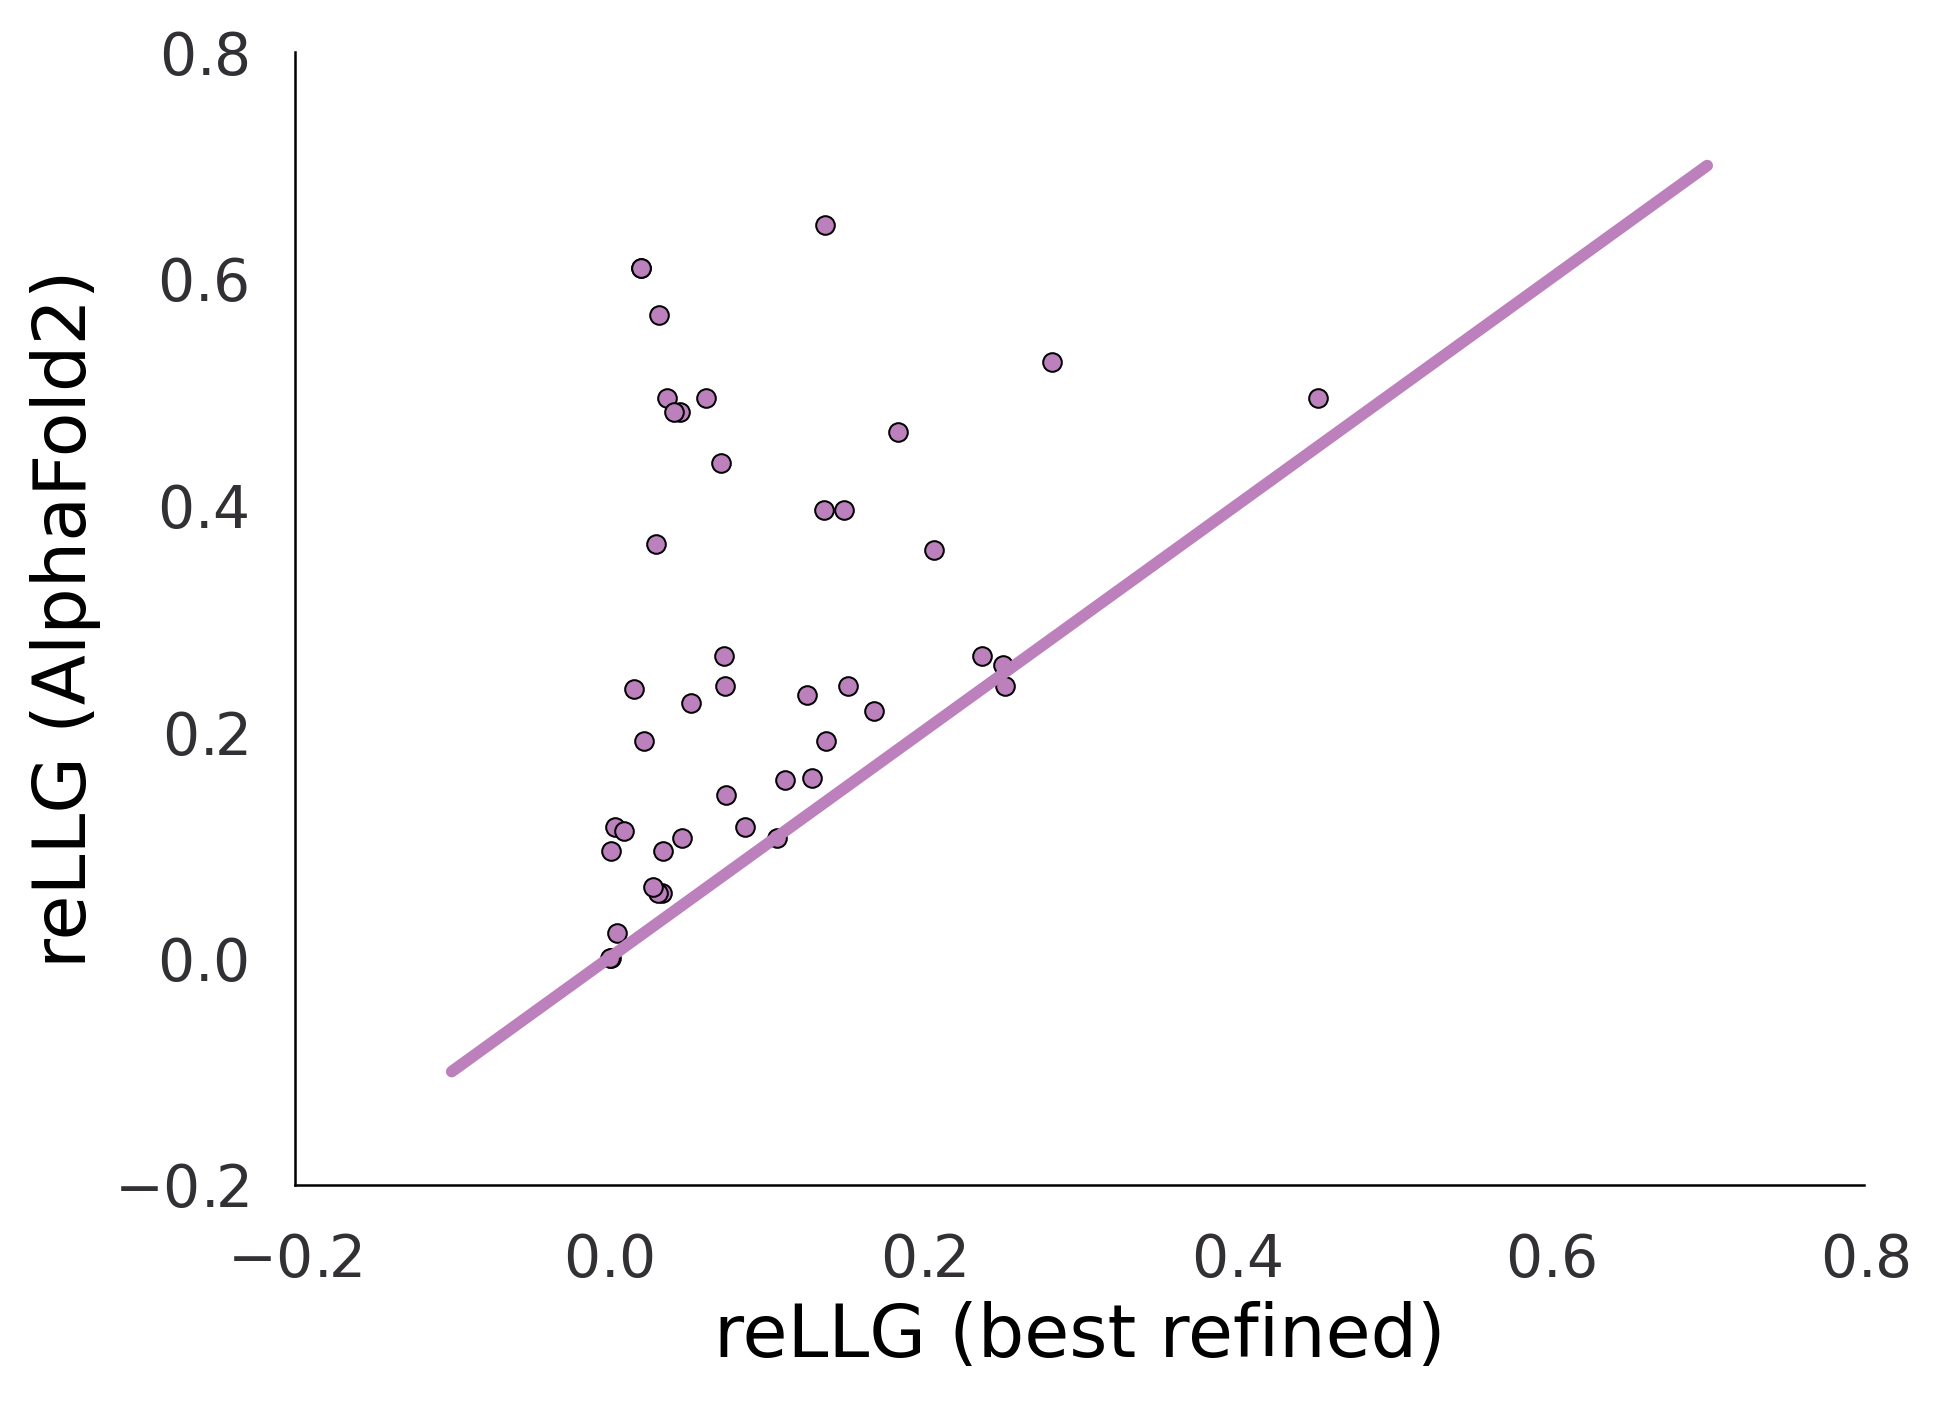

In [ ]:
# Get the best for each target in refinement and compare to alphafold
#display(df_models) # all models, not onlt model 1

#check_1074 = df_models.copy(deep=True)
#check_1074 = check_1074.loc[check_1074['Target'].str.contains("1074")]
#check_1074.sort_values(ascending=False,inplace=True,by="reLLG_as_rmsd")
#display(check_1074)

rank_best_targets = df_models.groupby(['Target_Evaluation'])['reLLG_as_rmsd'].max()
rank_best_targets.sort_values(ascending=False,inplace=True)
#print(rank_best_targets)
#print(len(rank_best_targets))
df_best_targets = rank_best_targets.to_frame()
df_best_targets['Target_Evaluation'] = df_best_targets.index
#df_best_targets.reset_index()
df_best_targets["Target_with_domain"] = df_best_targets["Target_Evaluation"].str[1:]
df_best_targets["Target"] = df_best_targets["Target_Evaluation"].str[1:5]
#display(df_best_targets)
#best_of_best = df_best_targets.groupby(['Target'])['reLLG_as_rmsd'].max()
#display(best_of_best)

# Then, I read in another dataframe that has the same but from alphafold
best_alpha = pd.read_csv("/content/drive/MyDrive/DATA_FOR_NOTEBOOKS/bestalphafold.csv")
best_alpha["Target_with_domain"] = best_alpha["Target_Evaluation"].str[1:]
best_alpha["Target"] = best_alpha["Target_Evaluation"].str[1:5]
#print('UNIQUE? ',len(best_alpha['Target'].unique()))
#display(best_alpha)

merge_for_plot = pd.merge(df_best_targets,best_alpha,on='Target')
#print("SHERLOCK initial merge")
#display(merge_for_plot)
#print("SHERLOCK initial merge")
# Eliminate those with inconsistencies in the domains
# indexes to remove: 4,5, 10, 11, 13, 15, 17, 26, 29, 30, 35, 37,39,48,49
merge_for_plot.drop([4,5, 10, 11, 13, 15, 17, 26, 29, 30, 35, 37,39,48,49],inplace=True)
#merge_for_plot.reset_index(inplace=True)

display(merge_for_plot)
#print(1/0)

ax = merge_for_plot.plot.scatter('reLLG_as_rmsd_x','reLLG_as_rmsd_y',figsize=(6.75,5),s=20,fontsize=14)
ax.set_xlabel('reLLG (best refined)')
ax.set_ylabel('reLLG (AlphaFold2)')
#ax.set_xlim(-0.1,0.7)
#ax.set_ylim(-0.1,0.7)
plt.plot([-0.1,0.7],[-0.1,0.7])
plt.show()

del df_best_targets # Just to make sure it does not stay in the notebook with previous values